## Load packages

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the data

Utilizing the [Numenta Anomaly Benchmark](https://github.com/numenta/NAB) dataset. This dataset provides artificial timeseries data containing labeled anomalies.

The `art_daily_small_noise.csv` file is utilized to train the model while the `art_daily_jumpsip.csv` file is used for testing. 

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [3]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


## Visualize the data

### Timeseries data with no anomalies
The training set

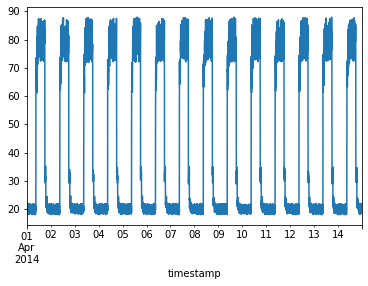

In [17]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

img_format = "svg"
image_name = "default_noise.svg"

fig.savefig(image_name, format = img_format, dpi = 1200)

### Timeseries data with anomalies
The testing set expressing anomalous data.

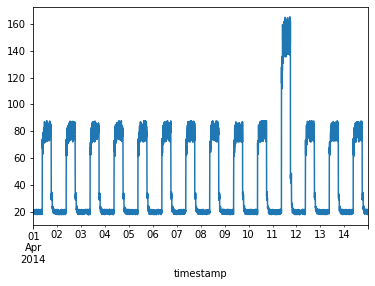

In [18]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

image_name2 = "noise_anomaly.svg"

fig.savefig(image_name2, format = img_format, dpi = 1200)

## Preparing training data
Normalize the training timeseries data.

The training data is normalized in this following fashion:

* 25 * 60 / 5 = 288 timesteps per day
    * Value occurs every 5 minutes
* 288 * 14 = 4032 data points
    * This lasts for a 14 day period

In [6]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### Creating usable sequences
Create sequences combining the total calculated timesteps (288) from the training data.

In [7]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


## Build the model
This is the architecture of a convolutional reconstruction autoencoder model. It expressly takes an input shape of (`sequence_length`, `num_features`) however, in reality it also has an additional primary input of `batch_size`. This input is not set and is thus left at NONE. In practice I have found that setting `batch_size` is best done in the `model.fit` ensemble of the model run to avoid many issues on input shape. In this case, `sequence_length` is set to 288 and `num_features` is set to 1; accordingly to the x_train.shape slices.

In [8]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-10-12 10:52:05.362861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-12 10:52:05.363047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## Model Training
In this instance `x_train` is utilized as both the input and the target as this is a reconstruction model.

In [9]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50


2022-10-12 10:52:36.755572: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-12 10:52:37.102693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 4s 21ms/step - loss: 0.6942 - val_loss: 0.2004
Epoch 2/50
 5/27 [====>.........................] - ETA: 0s - loss: 0.1482

2022-10-12 10:52:40.309456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 12ms/step - loss: 0.1152 - val_loss: 0.0514
Epoch 3/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0748 - val_loss: 0.0423
Epoch 4/50
27/27 [==============================] - 0s 10ms/step - loss: 0.0619 - val_loss: 0.0379
Epoch 5/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0545 - val_loss: 0.0340
Epoch 6/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0486 - val_loss: 0.0308
Epoch 7/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0439 - val_loss: 0.0288
Epoch 8/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0402 - val_loss: 0.0263
Epoch 9/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0373 - val_loss: 0.0288
Epoch 10/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0347 - val_loss: 0.0251
Epoch 11/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0328 - val_loss: 0.0241
Epoch 12/50
27/27 [========

Plotting training and validation loss.

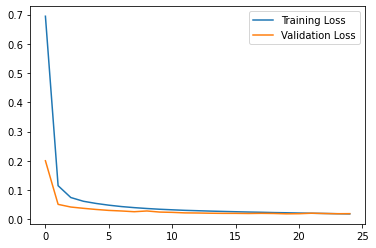

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

 68/118 [================>.............] - ETA: 0s

2022-10-12 10:54:17.529534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


118/118 [==============================] - 1s 6ms/step


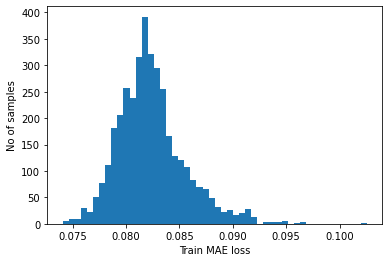

Reconstruction error threshold:  0.10256166943913304


In [11]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## Reconstruction comparison plot

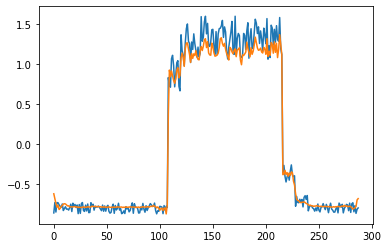

In [12]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

## Test Data Preperation

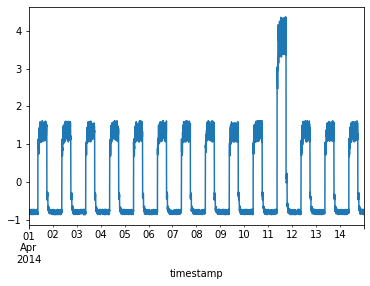

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 0s 2ms/step


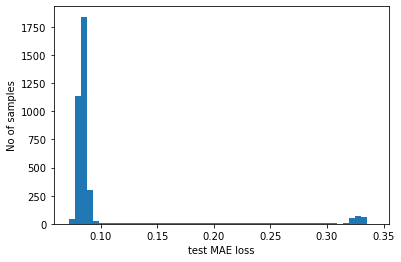

Number of anomaly samples:  392
Indices of anomaly samples:  (array([2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711,
       2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722,
       2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733,
       2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744,
       2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755,
       2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766,
       2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777,
       2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799,
       2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810,
       2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821,
       2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832,
       2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2

In [13]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [14]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

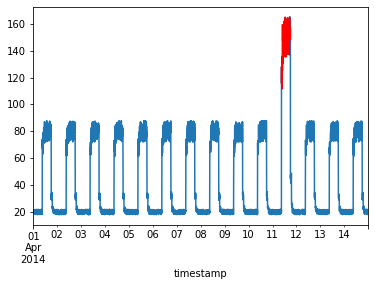

In [19]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

img_name3 = "Anomaly_Detected.svg"
fig.savefig(img_name3, format = img_format, dpi = 1200)